# Importing the dependencies

In [50]:
!pip install clean-text[gpl]


     |████████████████████████████████| 235 kB 13.3 MB/s 


In [48]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import YelpReviewPolarity
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from nltk import word_tokenize, sent_tokenize, RegexpTokenizer
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from tqdm.notebook import tqdm



nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Downloading and preparing dataset

In [2]:
# run this cell to prepare your data


# sample
def sample_k_array(mat, k, labels=2):
  data = []
  for label in range(1, labels + 1):
    temp_mat = mat[mat[:,0] == label]
    temp_array = temp_mat[np.random.choice(temp_mat.shape[0], k, replace=False), :]
    for item in temp_array:
      data.append(item)
  return np.array(data)

# download dataset
YelpReviewPolarity(root='.', split=('train', 'test'))

# reading train & test data
train_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/train.csv')
val_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/test.csv')

# renaming columns
train_dataframe = train_dataframe.rename(columns={\
    train_dataframe.columns[0]: 'label', train_dataframe.columns[1]: 'text'})

val_dataframe = val_dataframe.rename(columns={\
    val_dataframe.columns[0]: 'label', val_dataframe.columns[1]: 'text'})


train_mat = train_dataframe.values
val_mat = val_dataframe.values
train_data = sample_k_array(train_mat, 5000)
val_data = sample_k_array(val_mat, 1000)
train_data = pd.DataFrame({
    'text': train_data[:, 1],
    'label': train_data[:, 0]
})
val_data = pd.DataFrame({
    'text': val_data[:, 1],
    'label': val_data[:, 0]
})
train_data['label'] -= 1
val_data['label'] -= 1

In [3]:
# download Glove 100-dim vectors
glove_embedding = GloVe(name='6B', dim=100)

In [4]:
train_data

,text,label
0,run by assholes. major plumbing issues. wher...,0
1,I'm writing this as an update to my last revie...,0
2,What a sad disaster of a place. The faded glor...,0
3,Hooter's attracts a unique mix of people. In t...,0
4,Until the University of Wisconsin can convince...,0
...,...,...
9995,"I'm from Chicago suburbs, so I'm used to towni...",1
9996,"I have had pizza from here a few times, with m...",1
9997,This place is delicious!! I love that it feel...,1
9998,DELICIOUS seafood.\n\nMy friend and I arrived ...,1


In [5]:
val_data

,text,label
0,travelodge would have been the same but a lot ...,0
1,Last two times my husband went here to get me ...,0
2,Save your money and go to the many other nearb...,0
3,"Stores aren't that exciting, food selection su...",0
4,I have been to this school a few times to take...,0
...,...,...
1995,This is our neighborhood spot for ceviche... t...,1
1996,This was a surprisingly great find - the menu ...,1
1997,Good as always. Had the pesto chicken and sun ...,1
1998,What a pleasant surprise!!! Great little Sush...,1


In [21]:
def count_words(sentence):
    return len(sentence.split(' '))

In [7]:
def convert_to_glove(tokenized):
    temp = []
    for word in tokenized:
        temp.append(glove_embedding[word])
    return temp

def remove_stop_words(tokenized):
    return [word for word in tokenized if not word in stopwords.words()]

In [51]:
import re
from nltk.corpus import stopwords

def remove_stop_words_quick(sentence):
    cachedStopWords = stopwords.words("english")
    pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')
    return pattern.sub('', sentence)

In [67]:
from cleantext import clean
def clean_sentences(sentence):
    return clean(sentence,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=False,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=True,                 # remove punctuations
        lang="en"    )                   # set to 'de' for German special handling

def remove_small_len(sentence):
    return str.join(' ',[item if len(item)>2 else '' for item in word_tokenize(sentence) ])

In [54]:
train_data['text_cleaned'] = train_data['text'].apply(clean_sentences)
train_data['text_cleaned'] = train_data['text_cleaned'].apply(remove_stop_words_quick)
train_data['text_cleaned'] = train_data['text_cleaned'].apply(remove_small_len)

In [75]:
val_data['text_cleaned'] = val_data['text'].apply(clean_sentences)
val_data['text_cleaned'] = val_data['text_cleaned'].apply(remove_stop_words_quick)
val_data['text_cleaned'] = val_data['text_cleaned'].apply(remove_small_len)

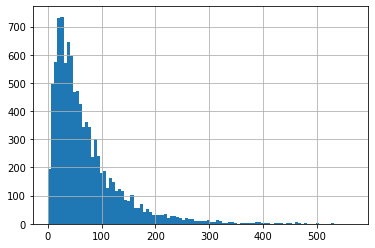

In [69]:
train_data['text_cleaned'].apply(count_words).hist(bins=100)

In [10]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [11]:
batch_size = 128

In [71]:
train_data['text_cleaned'].apply(word_tokenize)

0       [run, assholes, major, plumbing, issues, begin...
1       [writing, update, last, review, since, last, u...
2       [sad, disaster, place, faded, glory, overwhelm...
3       [hooters, attracts, unique, mix, people, hotel...
4       [university, wisconsin, convince, band, direct...
                              ...                        
9995    [chicago, suburbs, used, townie, dive, bars, p...
9996    [pizza, times, mixed, results, generally, posi...
9997    [place, delicious, love, feels, youre, walking...
9998    [delicious, seafood, friend, arrived, promptly...
9999    [sure, already, reviewed, place, already, stum...
Name: text_cleaned, Length: 10000, dtype: object

In [76]:
from tqdm.notebook import tqdm

class CustomDataset(Dataset):

    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        data_frame_row = self.data.loc[idx]
        raw_text = data_frame_row['text_cleaned'].lower()
        splitted_text = word_tokenize(raw_text)
        label = data_frame_row['label']

        number_of_words = 200
        seq_embbeding = np.zeros((number_of_words, 100))
        for idx, token in enumerate(splitted_text):
            if idx>= number_of_words:
              break
            seq_embbeding[idx, :] = glove_embedding[token]
        
        seq_embbeding = torch.Tensor(seq_embbeding)
        return seq_embbeding, label
        


train_loader = DataLoader(CustomDataset(train_data[['text_cleaned','label']]), batch_size = batch_size, shuffle = True)
val_loader = DataLoader(CustomDataset(val_data[['text_cleaned','label']]), batch_size = batch_size, shuffle = True)

In [77]:
x,y=next(iter(train_loader))
x.shape

torch.Size([128, 200, 100])

# Defining Model

In [81]:
class YelpClassifier(nn.Module):

    def __init__(self):
        super(YelpClassifier,self).__init__()


        self.lstm = nn.LSTM(input_size=100,hidden_size=64, num_layers=2,
                            batch_first=True)
        
        self.fc2 = nn.Sequential(
            nn.Linear(64,16),
            nn.ReLU(),

            nn.Linear(16,2)
        )

        self.loss_ = nn.CrossEntropyLoss()


    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:,-1,:]
        x = self.fc2(x)
        return x

  
    def loss(self, outputs, targets):
        return self.loss_(outputs, targets)

In [82]:
print(YelpClassifier())

YelpClassifier(
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc2): Sequential(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
  (loss_): CrossEntropyLoss()
)


# Training & Evaluation

In [88]:
from sklearn.metrics import f1_score
# your code

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

def eval_model(model, data_loader, device):

    n = len(data_loader.dataset)
    model.eval()

    sum =0 
    with torch.no_grad():
        for x, y in data_loader:
            x= x.to(device)
            y=y.to(device)
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, axis=-1)
            sum = sum + f1_score(y,y_pred)*x.shape[0]
    
    return sum/n

def train(model, train_loader, val_loader, optimizer, num_epochs, device):

    train_loss_history = np.zeros((num_epochs,))
    val_loss_history = np.zeros((num_epochs,))
    train_f1_history = np.zeros((num_epochs,))
    val_f1_history = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        train_loss = 0
        model.train()
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = model.loss(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.shape[0]
        
        train_loss = train_loss / len(train_loader.dataset)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x,y= x.to(device),y.to(device)
                n = x.shape[0]
                y_pred = model(x).to(device)
                loss = model.loss(y_pred, y)
                val_loss += loss.item() * x.shape[0]

        val_loss = val_loss / len(val_loader.dataset)

        train_f1,val_f1 = eval_model(model, train_loader, device),eval_model(model, val_loader, device)

        train_loss_history[epoch] = train_loss
        val_loss_history[epoch] = val_loss
        train_f1_history[epoch] = train_f1
        val_f1_history[epoch] = val_f1

        print(f"Epoch {epoch + 1} / {num_epochs} Training Loss = {train_loss:.5f} Test Loss = {val_loss:.5f}")
        print(f"Training F1 score = {train_f1:.5f} F1 score = {val_f1:.5f}")
    
    return train_loss_history, val_loss_history, train_f1_history, val_f1_history

n_epochs = 15
model = YelpClassifier()
model=model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss,test_loss,train_f1,test_f1 = train(model, train_loader, val_loader, optimizer, n_epochs, device)

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 / 15 Training Loss = 0.69156 Test Loss = 0.68818
Training F1 score = 0.66565 F1 score = 0.66830


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 / 15 Training Loss = 0.68849 Test Loss = 0.68924
Training F1 score = 0.67104 F1 score = 0.67082


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 / 15 Training Loss = 0.68673 Test Loss = 0.68628
Training F1 score = 0.66791 F1 score = 0.66998


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 / 15 Training Loss = 0.68551 Test Loss = 0.66303
Training F1 score = 0.03550 F1 score = 0.02844


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 / 15 Training Loss = 0.68491 Test Loss = 0.68930
Training F1 score = 0.67036 F1 score = 0.66847


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 / 15 Training Loss = 0.68575 Test Loss = 0.68638
Training F1 score = 0.67233 F1 score = 0.67136


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 / 15 Training Loss = 0.68232 Test Loss = 0.68435
Training F1 score = 0.67488 F1 score = 0.67289


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 / 15 Training Loss = 0.66202 Test Loss = 0.63895
Training F1 score = 0.64105 F1 score = 0.64802


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 / 15 Training Loss = 0.63382 Test Loss = 0.68838
Training F1 score = 0.68312 F1 score = 0.68335


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 / 15 Training Loss = 0.67630 Test Loss = 0.68321
Training F1 score = 0.67358 F1 score = 0.67372


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 / 15 Training Loss = 0.69597 Test Loss = 0.69019
Training F1 score = 0.04169 F1 score = 0.03263


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 / 15 Training Loss = 0.68631 Test Loss = 0.68060
Training F1 score = 0.33392 F1 score = 0.32858


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 / 15 Training Loss = 0.68480 Test Loss = 0.69133
Training F1 score = 0.67496 F1 score = 0.67883


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 / 15 Training Loss = 0.67444 Test Loss = 0.67321
Training F1 score = 0.37642 F1 score = 0.36285


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 / 15 Training Loss = 0.67085 Test Loss = 0.66854
Training F1 score = 0.37877 F1 score = 0.36536


# Draw Loss & F1-score

Text(0.5, 1.0, 'f1')

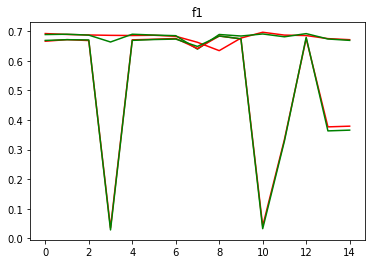

In [89]:
# your code
plt.plot(np.arange(0, n_epochs), train_loss, color = 'r', label = 'train')
plt.plot(np.arange(0, n_epochs), test_loss, color = 'g', label = 'test')
plt.title("loss")

plt.plot(np.arange(0, n_epochs), train_f1, color = 'r', label = 'train')
plt.plot(np.arange(0, n_epochs), test_f1, color = 'g', label = 'test')
plt.title("f1")